# Validation of method

### Table of contents

1. [**Heteroscedastic GP**](#hetero)
3. [**Renewal process GP**](#renewal)
4. [**GP-GLM**](#gpglm)

In [ ]:
%load_ext autoreload
%autoreload 2

In [81]:
import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

## 1D

In [82]:
x_dims = 1
f_dims = 3
jitter = 1e-8

In [97]:
len_fx = 1.*np.ones((f_dims, x_dims))  # GP lengthscale
var_f = 1.0*np.ones(f_dims)  # kernel variance
kern = lib.GP.kernels.SquaredExponential(f_dims, variance=var_f, lengthscale=len_fx)
mean_f = np.zeros(f_dims)
num_induc = 10

prng_state = jax.random.PRNGKey(123)
prng_seeds = jax.random.split(prng_state)

induc_locs = jax.random.normal(prng_seeds[0], shape=(f_dims, num_induc, x_dims))


mode = 'tSVGP'
if mode == 'qSVGP':
    u_mu = 1.*jax.random.normal(prng_seeds[1], shape=(f_dims, num_induc, 1))
    u_Lcov = 0.1*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)

    svgp = lib.GP.sparse.qSVGP(kern, mean_f, induc_locs, u_mu, u_Lcov, RFF_num_feats=100, whitened=False)
    
elif mode == 'tSVGP':
    lambda_1 = 10.*jax.random.normal(prng_seeds[1], shape=(f_dims, num_induc, 1))
    chol_Lambda_2 = 10.*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)

    svgp = lib.GP.sparse.tSVGP(kern, mean_f, induc_locs, lambda_1, chol_Lambda_2, RFF_num_feats=0)
    
    Kzz = svgp.kernel.K(svgp.induc_locs, None, False)
    u_mu, u_Lcov = lib.GP.sparse.t_to_q_svgp_moments(Kzz, lambda_1, chol_Lambda_2, 1e-12)

In [103]:
num_samps = 33
xx = np.linspace(-15., 15., 100)[None, None, :, None]

pf_x = svgp.sample_prior(prng_state, xx.repeat(num_samps, axis=0), jitter)  # (evals, samp, f_dim)

qf_m, qf_c, _, _ = svgp.evaluate_posterior(
    xx, mean_only=False, diag_cov=False, compute_KL=False, compute_aux=False, jitter=jitter)

qf_x, KL = svgp.sample_posterior(
    prng_state, xx.repeat(num_samps, axis=0), jitter, compute_KL=True) # (evals, samp, f_dim)

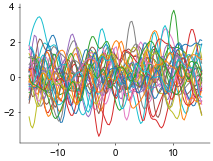

In [104]:
x_dim = 0
f_dim = 0
tr = list(range(num_samps))

plt.plot(xx[0, f_dim, :, x_dim], pf_x[tr, f_dim, :].T, alpha=1.)
plt.show()

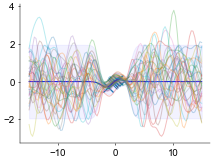

In [105]:
f_dim = 0
x_dim = 0
tr = list(range(num_samps))

n_ps = qf_c.shape[-2]
#qf_v = qf_c[f_dim, tr, 0]
qf_v = qf_c[0, f_dim, np.arange(n_ps), np.arange(n_ps)]
lb = qf_m[0, f_dim, :, 0] - 1.96 * qf_v ** 0.5
ub = qf_m[0, f_dim, :, 0] + 1.96 * qf_v ** 0.5
m = qf_m[0, f_dim, :, 0]

x = xx[0, f_dim ,:, x_dim]

plt.plot(x, m, 'b', label='posterior mean')
plt.fill_between(x, lb, ub, color='b', alpha=0.05, label='95% confidence')
plt.plot(x, qf_x[tr, f_dim, :].T, alpha=0.3)
plt.scatter(induc_locs[f_dim, :, x_dim], u_mu[f_dim, :, 0], marker='x', s=100)
plt.show()

In [101]:
xx_ = np.linspace(-5., 5., 300)[None, None, :, None]
qf_x_, KL = svgp.sample_posterior(
    prng_state, xx_.repeat(num_samps, axis=0), jitter, compute_KL=True) # (evals, samp, f_dim)

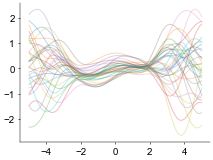

In [102]:
f_dim = 0
x_dim = 0
tr = list(range(num_samps))

plt.plot(xx_[0, f_dim, :, x_dim], qf_x_[tr, f_dim, :].T, alpha=0.3)
plt.show()

<a id='ssgp'></a>
## SSGP

In [26]:
x_dims = 3
num_samps = 5
prng_state = jax.random.PRNGKey(123)

jitter = 1e-6


### state space GP ###
var_x = 1.0*np.ones((x_dims))  # GP variance
len_x = 1.0*np.ones((x_dims, 1))  # GP lengthscale

kernx = lib.GP.kernels.Matern12(x_dims, variance=var_x, lengthscale=len_x)


num_samps = 20
Tsteps = 1000

site_locs = np.linspace(0., 5., Tsteps)  # s
#timedata = (jnp.array(t), jnp.diff(t)[:1])

evalsteps = 3000
t_eval = jnp.linspace(-2.0, 7.0, evalsteps)
        

# site_init
site_obs = 0. * np.ones([Tsteps, x_dims, 1]) + np.random.randn(Tsteps, x_dims, 1)
site_Lcov = 1. * np.eye(x_dims)[None, ...].repeat(Tsteps, axis=0)

state_space = lib.GP.markovian.GaussianLTI(
    kernx, site_locs, site_obs, site_Lcov, diagonal_site=True, fixed_grid_locs=True)



prior_samples = state_space.sample_prior(
    prng_state, num_samps, t_eval, jitter)

#t_eval = None
post_mean, post_cov, _ = state_space.evaluate_posterior(
    t_eval, mean_only=False, compute_KL=False, jitter=1e-8)
post_mean = post_mean[..., 0]

post_samples, _ = state_space.sample_posterior(
    prng_state, num_samps, t_eval, jitter, False)  # (time, tr, N)

#t_eval = t

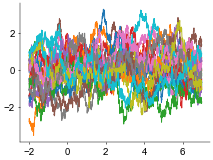

In [27]:
for n in range(num_samps):
    plt.plot(t_eval, prior_samples[:, n, 1])
             
plt.show()

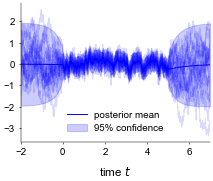

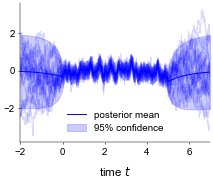

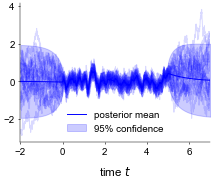

In [28]:
post_var = post_cov[:, np.arange(state_space.markov_kernel.out_dims), np.arange(state_space.markov_kernel.out_dims)]
lb = post_mean - 1.96 * post_var ** 0.5
ub = post_mean + 1.96 * post_var ** 0.5

for plot_out in range(state_space.markov_kernel.out_dims):
    plt.figure()
    plt.plot(t_eval, post_mean[:, plot_out], 'b', label='posterior mean')
    plt.fill_between(t_eval, lb[:, plot_out], ub[:, plot_out], color='b', alpha=0.2, label='95% confidence')
    plt.plot(t_eval, post_samples[..., plot_out, 0], 'b', alpha=0.15)
    plt.xlim([t_eval[0], t_eval[-1]])
    plt.legend()
    plt.xlabel('time $t$')
    plt.show()

<a id='hetero'></a>
## Heteroscedastic GP

In [8]:
def get_stat_model(mu, lsigma, log_beta, log_gamma, len_x, kernel_class, neurons):
    """
    """
    f_dims = neurons
    x_dims = f_dims
    
    v_t = 1.*np.ones(neurons)
    v_r = -.3*np.ones(neurons)
    tau_m = 0.01*np.ones(neurons)
    tau_s = np.ones(neurons)
    log_beta = log_beta*np.ones(neurons)
    log_gamma = log_gamma*np.ones(neurons)
    
    tau_h = 0.1*np.ones(neurons)
    a = 1.0*np.ones(neurons)
    b = 1000.0*np.ones(neurons)

    IF_model = lib.IF_models.LIF(log_beta, log_gamma, v_t, v_r, tau_s, tau_m)#, tau_h, a, b)
    
    eps_mapping = lib.mappings.Identity(f_dims)

    ### state space GP ###
    var_x = 1.0*np.ones(x_dims)  # GP variance
    len_x = len_x*np.ones((x_dims, 1))  # GP lengthscale

    kernx = kernel_class(x_dims, variance=var_x, lengthscale=len_x)
    #kernx = lib.kernels.IID(jnp.eye(x_dims))
    
    state_space = lib.GP.state_space.FullLDS(kernx, diagonal_site=True)

    ### mu and sigma ###
    params = {'value': mu*jnp.ones((f_dims,))}
    mu_mapping = lib.mappings.Constant(x_dims, f_dims, params)

    params = {'value': lsigma*jnp.ones((f_dims,))}
    lsigma_mapping = lib.mappings.Constant(x_dims, f_dims, params)
    
    ### initial conditions ###
    q_vh_ic = jnp.zeros((num_samps, neurons, IF_model.q_d))
    
    ### IF GP model ###
    model = lib.inference.IF_SSGP(
        state_space, eps_mapping, mu_mapping, lsigma_mapping, IF_model, q_vh_ic, dtype=jnp.float64)
    return model

<a id='Renewal process GP'></a>
## Renewal process GP

In [9]:
neurons = 2
num_samps = 5
prng_state = jax.random.PRNGKey(123)

model = get_stat_model(
    0.1, -0.5, 3., 3., 0.01, lib.GP.kernels.Matern12, neurons)


Tsteps = 1000
t = np.linspace(0., 5., Tsteps)  # s
x_obs = jnp.empty((t.shape[0], 1, 0))
y = np.zeros((t.shape[0], neurons))
#mask = np.ones_like(y).astype(bool)
#mask[:, 0] = False
mask = None
model.set_data(t, x_obs, y, mask=mask)

In [10]:
spiketrains, q_vh, I, eps_samples = model.sample_prior_spikes(
    prng_state, num_samps, x_obs=None, timedata=None)


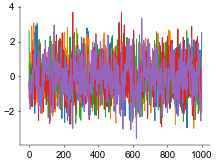

In [11]:
for n in range(num_samps):
    plt.plot(eps_samples[:, n, 1])
             
plt.show()

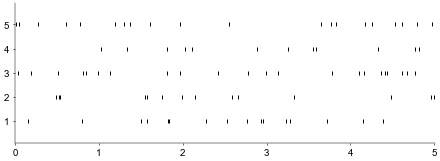

In [13]:
fig = plt.figure(figsize=(6, 2))

widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, 
                         height_ratios=heights, top=1.0, bottom=0.0, left=.0, right=1.0)

ax = fig.add_subplot(spec[0, 0])
    
lib.utils.plots.raster_plot((fig, ax), spiketrains[:, :, 0].T, 
                     time_bins=Tsteps, bin_time=model.dt[1], units=num_samps, colors=None, marker='|', markersize=10)

plt.show()

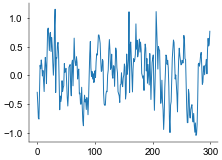

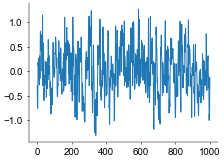

In [14]:
plt.plot(q_vh[:300, 0, 0, 0])
plt.show()

plt.plot(q_vh[:, 0, 0, 1])
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator # for minor ticks
from matplotlib import gridspec
from matplotlib import patches
from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox

import numpy as np

import scipy.stats as scstats
import scipy.special as sps

import sys
sys.path.append("../..")

from neuroprob.utils import stats, tools, neural_utils, biophysical
import neuroprob.models as mdl

dev = tools.PyTorch()

plt.style.use(['paper.mplstyle'])

### Inhomogenous Gamma process

The inhomogeneous Gamma point process likelihood with rate $\lambda(t)$ is 
\begin{equation}
    p(t_1, \ldots, t_n) = \frac{\Gamma(\alpha, \Lambda(t_1)) \Gamma(\alpha, \Lambda(t_n))}{\Gamma(\alpha)^n} \cdot \left[ \prod_{i=1}^n \lambda(t_i) \right] \cdot \left[ \prod_{i=2}^n(\Lambda(t_i) - \Lambda(t_{i-1}))^{\alpha-1} \right] \cdot e^{-(\Lambda(t_n) - \Lambda(t_1))}
\end{equation}
where $\Lambda(t) = \int_0^t \lambda(\tau) \mathrm{d}\tau$ and $\Gamma(\alpha, x)$ denotes the regularized upper incomplete Gamma function. It satisfies $\Gamma(\alpha, x) = 1 - G(\alpha, x)$ with 
\begin{equation}
G(\alpha n, \lambda T) = \frac{1}{\Gamma(n\alpha)} \int_0^T \lambda^{n\alpha} \tau^{n\alpha - 1} e^{-\lambda \tau} \cdot \mathrm{d}\tau
\end{equation}
called the regularized lower incomplete Gamma function. The Gamma count process probability is given by 
\begin{equation}
    Pr(N_T = n) = G(\alpha n, \lambda T) - G(\alpha (n+1), \lambda T)
\end{equation}
This distribution has $\mathbb{E}[N_T] = \sum_{k=1}^{\infty} G(\alpha k, \lambda T)$.

Let us consider the interspike intervals (ISIs), which are drawn from $Gamma(\tau|\alpha,\lambda)$. The derivation for $Pr(N_T = n)$ can then be seen intuitively using the fact that $\tau_1 + \tau_2 \sim Gamma(\tau|\alpha_1 + \alpha_2,\lambda)$. The first term is thus the probability that $n$ ISIs have a total sum below $T$, while the second term is the probability adding another ISI goes over the counting interval $T$. Note that except for the case $\alpha = 1$ (exponential distribution), $\mathbb{E}[\tau]^{-1} \neq \mathbb{E}[N_T]$. Hence the rate parameter appearing in $\mathbb{E}[\tau] = \frac{\alpha}{\lambda}$ cannot be interpreted as the 'rate' similar to the Poisson point process.

The occupancy normalized histograms used to provide a non-parametric estimate of place fields are equivalent to calculating the point estimate of $\mathbb{E}[N_T]$ for $T=1$, which by the above analysis shows this generally is a biased estimator of the underlying $\mathbb{E}[\tau]^{-1} = \frac{\lambda}{\alpha}$ in that bin. However, numerically the values are close over a wide range of $\alpha$. The differences are noticeable below $\alpha \approx 0.82$ when the bias is $>0.1$, with positive bias showing that naively using occupancy normalized histograms compensated by the shape overestimates the actual rate.

Additionally, we assumed $\mathbb{E}[N_{T_1}] + \mathbb{E}[N_{T_2}] = \mathbb{E}[N_{T_1+T_2}]$, which only holds approximately for Gamma count processes. We need $T \gg \frac{\alpha}{\lambda}$ in order to be able to ignore the effects of the renewal point process at the bin edges.

In [ ]:
rate = 10.0
shape = 0.5

fig = plt.figure(figsize=(8,4))
gs1 = fig.add_gridspec(nrows=1, ncols=2, wspace=0.2, bottom=0.6, top=0.95)
ax = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])


bins = np.arange(31)
prbs = stats.gamma_count_prob(bins, rate, 1.0, 1.0)
ax.plot(bins, prbs, color='r', label=r'Poisson')
shape = 0.5
prbs2 = stats.gamma_count_prob(bins, rate*shape, 1.0, shape)
ax.bar(bins, prbs2, width=1, color='cyan', edgecolor='grey', linewidth=1)
ax.set_xlim(-0.5, 30.5)
ax.set_yticks([])
ax.set_ylabel('probability')
ax.legend()

ax.text(-0.18, 1.05, 'A', transform=ax.transAxes, size=15)#, weight='bold') # string.ascii_uppercase[n]
ax.text(0.25, 0.1, r'$\alpha=\frac{1}{2}$', transform=ax.transAxes, size=12)


prbs = stats.gamma_count_prob(bins, rate, 1.0, 1.0)
ax2.plot(bins, prbs, color='r')
shape = 2.0
prbs2 = stats.gamma_count_prob(bins, rate*shape, 1.0, shape)
ax2.bar(bins, prbs2, width=1, color='cyan', edgecolor='grey', linewidth=1)
ax2.set_xlim(-0.5, 30.5)
ax2.set_yticks([])

fig.text(-0.12, -0.28, 'spike count', transform=ax2.transAxes, fontsize=12, ha='center')
ax2.text(0.25, 0.1, r'$\alpha=2$', transform=ax2.transAxes, size=12)


gs2 = fig.add_gridspec(nrows=1, ncols=3, wspace=0.4, bottom=0.05, top=0.45)
ax = fig.add_subplot(gs2[0, 0])
ax2 = fig.add_subplot(gs2[0, 1:])

# checking correspondence of ISI average to count average
eps = 5*1e-2
alpha_arr = np.linspace(0.2, 3.0, 1000)
beta = 100.0

avg_count = []
avg_invISI = []
for alpha in alpha_arr:
    h = 0
    add = 1
    n = 1
    while add > 1e-4:
        add = sps.gammainc(alpha*n, beta)
        h += add
        n += 1
    avg_count.append(h)
    avg_invISI.append(beta/alpha)
        
ax.text(-0.3, 1.0, 'B', transform=ax.transAxes, size=15)
ax.plot(alpha_arr, np.array(avg_count), label=r'$\mathbb{E}[N]$')
ax.plot(alpha_arr, np.array(avg_invISI), 'r--', label=r'$\mathbb{E}[\tau]^{-1}$')
ll = np.linspace(0, 6.9, 10)
ax.plot(np.ones_like(ll), ll, color='#dddddd')

ax.legend(frameon=False)
#ax.set_xlim(0.2, 3.0)
#ax.set_xticks([0.2, 1.0, 2.0])
#ax.set_ylim(0.0, 6.9)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('count')



# Spike trains
ax2.text(-0.15, 1.0, 'C', transform=ax2.transAxes, size=15)

trials = 5
sim_samples = 1000
sim_tbin = 0.001 # s
rate = np.empty((trials, 1, sim_samples))

rate.fill(5.0)
dist_isi = mdl.point_process.ISI_gamma(0.25)
s = mdl.point_process.gen_IRP(dist_isi, rate, sim_tbin)
for t in range(trials):
    s_ = s[t]
    ax2.scatter(s_*sim_tbin, np.ones_like(s_)*t, marker='|', color='b', s=40, 
                label=r'$\alpha=\frac{1}{4}$')

rate.fill(20.0)
dist_isi = mdl.point_process.ISI_gamma(1)
s = mdl.point_process.gen_IRP(dist_isi, rate, sim_tbin)
for t in range(trials):
    s_ = s[t]
    ax2.scatter(s_*sim_tbin, np.ones_like(s_)*(t+trials+1), marker='|', s=40, color='k', 
                label=r'$\alpha=1$')

rate.fill(80.0)
dist_isi = mdl.point_process.ISI_gamma(4)
s = mdl.point_process.gen_IRP(dist_isi, rate, sim_tbin)
for t in range(trials):
    s_ = s[t]
    ax2.scatter(s_*sim_tbin, np.ones_like(s_)*(t+2*trials+2), marker='|', s=40, color='g', 
                label=r'$\alpha=4$')
    
ll = np.linspace(.0, 1., 10)
ax2.plot(ll, np.ones_like(ll)*(trials), color='grey')
ax2.plot(ll, np.ones_like(ll)*(2*trials+1.), color='grey')

ax2.set_xlabel('time (s)')
ax2.set_ylim(-1.5, trials*3+0.5 + 2)
ax2.set_xlim(0.0, 1.0)

ax2.set_yticks([2, 8, 14])
ax2.set_yticklabels([r'$\alpha=\frac{1}{4}$  ', r'$\alpha=1$  ', r'$\alpha=4$  '])
ax2.tick_params(axis='y', which='both', length=0)

ax2.spines['left'].set_visible(False)


#plt.savefig('output/gamma_process.svg')
#plt.savefig('output/gamma_process.pdf')
plt.show()

### Adding counts

In [ ]:
# Turn into count process
sim_tbin = 0.001
sim_samples = 1000
trials = 10000
gg = []

rate = np.empty((trials, sim_samples))

rate[:, :] = 5.0
#rate[:, :sim_samples//2] = 100.0
#rate[:, sim_samples//2:] = 0.0

mode = 'gamma'
if mode == 'gamma':
    shape = 0.5
    renew = mdl.point_process.ISI_gamma(shape)
elif mode == 'invgauss':
    mu = 1.
    lambd = 1.
    renew = mdl.point_process.ISI_invGauss(mu, lambd)
elif mode == 'lognorm':
    mu = 0.1
    sigma = 1.
    renew = mdl.point_process.ISI_logNormal(mu, sigma)
    
s = mdl.point_process.gen_IRP(renew, rate[:, None], sim_tbin)
for k in range(len(s)):
    gg.append(len(s[k]))
    
    
ggg = []
rate[:, :] = 5.0
#rate[:, :sim_samples//2] = 100.0
#rate[:, sim_samples//2:] = 0.0

mode = 'gamma'
if mode == 'gamma':
    shape = 0.5
    renew = mdl.point_process.ISI_gamma(shape)
elif mode == 'invgauss':
    mu = 1.
    lambd = 1.
    renew = mdl.point_process.ISI_invGauss(mu, lambd)
elif mode == 'lognorm':
    mu = 0.1
    sigma = 1.
    renew = mdl.point_process.ISI_logNormal(mu, sigma)
    
s = mdl.point_process.gen_IRP(renew, rate[:, None], sim_tbin)
for k in range(len(s)):
    ggg.append(len(s[k]))



In [ ]:
gggg = []
for h in range(len(gg)):
    gggg.append(gg[h]+ggg[h])

fig, ax = plt.subplots()
bins = np.arange(50)
prbs = stats.gamma_count_prob(bins, 10.0, shape, sim_tbin*sim_samples)
ax.plot(bins, prbs, 'r--', label=r'theory ($\alpha$={})'.format(shape))
ax.hist(gg, bins=np.arange(50)-0.5, density=True, label='simulation')
ax.legend()
ax.set_xlabel('Spike count')
ax.set_ylabel('Probability')
plt.show()

fig, ax = plt.subplots()
bins = np.arange(100)
prbs = stats.gamma_count_prob(bins, 5.0, shape, sim_tbin*sim_samples)
ax.plot(bins, prbs, 'r--', label=r'theory ($\alpha$={})'.format(shape))
ax.hist(ggg, bins=np.arange(100)-0.5, density=True, label='simulation')
ax.legend()
ax.set_xlabel('Spike count')
ax.set_ylabel('Probability')
plt.show()

fig, ax = plt.subplots()
bins = np.arange(100)
prbs = stats.gamma_count_prob(bins, 15.0, shape, sim_tbin*sim_samples)
ax.plot(bins, prbs, 'r--', label=r'theory ($\alpha$={})'.format(shape))
ax.hist(gggg, bins=np.arange(100)-0.5, density=True, label='simulation')
ax.legend()
ax.set_xlabel('Spike count')
ax.set_ylabel('Probability')
plt.show()

In [ ]:
 elif ll_mode == "IPP":
        likelihood = nprb.likelihoods.Poisson_pp(
            tbin, inner_dims, inv_link, tensor_type=tensor_type
        )

    elif ll_mode == "IG":
        shape = torch.ones(inner_dims)
        likelihood = nprb.likelihoods.Gamma(
            tbin,
            inner_dims,
            inv_link,
            shape,
            allow_duplicate=True,
            tensor_type=tensor_type,
        )

    elif ll_mode_comps[0] == "IIG":
        mu_t = torch.ones(inner_dims)
        likelihood = nprb.likelihoods.inv_Gaussian(
            tbin,
            inner_dims,
            inv_link,
            mu_t,
            allow_duplicate=True,
            tensor_type=tensor_type,
        )

    elif ll_mode_comps[0] == "LN":
        sigma_t = torch.ones(inner_dims)
        likelihood = nprb.likelihoods.log_Normal(
            tbin,
            inner_dims,
            inv_link,
            sigma_t,
            allow_duplicate=True,
            tensor_type=tensor_type,
        )

### Refractory Poisson

There are two ways to simulate it: with the GLM framework or with the time-rescaled renewal processes

In [3]:
import neuroprob as mdl
from neuroprob import utils

dev = utils.pytorch.get_device() # PyTorch device

PyTorch version: 1.7.1+cu101
Using device: cuda:0


In [53]:
tbin = 0.001
Tsteps = 1000
refracts = [0.0, 0.001, 0.002, 0.004]
rp = np.ones((10000, 1, Tsteps))
cnts = []
rate_n = 10

for refract in refracts:
    for rate in np.linspace(1, 30, rate_n):
        ISI_dist = mdl.point_process.ISI_gamma(np.ones(1), loc=rate*refract)
        spike_ind = mdl.point_process.gen_IRP(ISI_dist, rate*rp, tbin)
        cnts.append(np.array([len(s) for s in spike_ind]))

In [54]:
cnts = np.array(cnts).reshape(len(refracts), rate_n, -1)

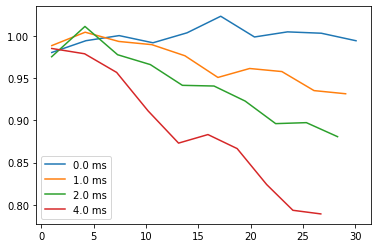

In [55]:
for k, r in enumerate(refracts):
    plt.plot(cnts.mean(-1)[k, :], (cnts.var(-1)/cnts.mean(-1))[k, :], label='{} ms'.format(r*1000))
    
plt.legend()

In [ ]:
# IPP-GLM with refractory
T = 50000
runs = 10

#T_int = 0
I_ext = np.zeros((runs, T))

sample_bin = 0.001
        
for r in range(runs):    
    I_ext[r, :] = r/5.


In [ ]:
hist_len = 100
VI_tuples = [(None, None, None, 1)]
covariates = [I_ext[:, :, None]]

input_group = mdl.inference.input_group(1, VI_tuples, stimulus_filter=None)
input_group.set_XZ(covariates, T, batch_size=5000, filter_len=hist_len, trials=runs)



# GLM validation with synthetic GLM data
#ivlink = 'exp'
ivlink = lambda x: torch.sigmoid(x)/sample_bin

glm_rate = mdl.parametrics.GLM(1, 1, 1, ivlink, bias=True)
glm_rate.set_params(np.array([[1.0]]), np.array([[-5.0]]))

_likelihood = mdl.likelihoods.Bernoulli(sample_bin, 1, ivlink)

syn_trains = []
taus = [0., 1., 2., 4.]
for tau_ in taus:
    a = np.array([[[-10.0]]])
    beta = np.array([[[10.0]]])
    tau = np.array([[[tau_]]])

    #hist_len = 99 # 100 steps of spiketrain, no instantaneous element
    hist_couple = mdl.filters.sigmoid_refractory(a=a, beta=beta, tau=tau, timesteps=hist_len-1, 
                                                 learnable=[False, False, False])


    likelihood = mdl.filters.filtered_likelihood(_likelihood, hist_couple)


    glm = mdl.inference.VI_optimized(input_group, glm_rate, likelihood)
    glm.to(dev)


    ini_train = np.zeros((10, 1, hist_len-2))
    MC = 1

    F_mu = glm.sample_F(covariates, MC=MC, F_dims=np.arange(1), trials=runs)
    syn_train, rate = glm.likelihood.sample(F_mu[None, ...], ini_train)
    
    syn_trains.append(syn_train)

In [ ]:
ss = []
for syn_train_ in syn_trains:
    ss.append(syn_train_.reshape(10, 5000, 10).sum(-1))

In [ ]:
ts =  [0, 1, 3]

for t in ts:
    ms = ss[t].mean(-1)
    plt.plot(ms/sample_bin/10)
    
plt.show()


for t in ts:
    ms = ss[t].mean(-1)
    vs = ss[t].var(-1)
    plt.plot(ms/sample_bin/10, vs/(ms+1e-12), label='{} ms'.format(int(taus[t])))
    
plt.ylabel('Fano factor')
plt.xlabel('firing rate (Hz)')
plt.legend()
plt.show()

In [ ]:
aa = np.where(syn_train[0, 0, :] != 0)[0]
plt.scatter(aa, np.zeros_like(aa))
plt.show()


a_t = hist_couple.compute_filter()
plt.plot(a_t.cpu().numpy()[0, 0, ::-1])

### Renewal process likelihood
Here we visualize the loss landscape for a renewal process likelihood.

In [ ]:
from neuroprob.utils import tools, neural_utils, stats
import neuroprob.models as mdl

from tqdm.autonotebook import tqdm

dev = tools.PyTorch() # PyTorch device

In [ ]:
samples = 100000
tbin = 0.001
shape_t = 3.0*np.ones(1) # true shape parameters

# renewal process model
renewal_dist = mdl.likelihoods.invGaussian(1, # neurons
                                     'exp', # inverse link
                                     shape_t, # shape parameters of Gamma process
                                     dequantize=True, # add noise to the spike times when fitting
                                     allow_duplicate=True) # when > 1 spikes per bin, don't treat as single spike
renewal_dist.set_params(tbin)
renewal_dist.to(dev) # move to device

In [ ]:
# sample synthetic spike train from renewal process
neuron = [0]
rate_t = np.empty((1, 1, samples)) # trials, neurons, timesteps
rate = 20.0
rate_t.fill(rate) # let's use a constant rate

spikes = renewal_dist.sample(rate_t, # rate function
                             neuron) # neuron(s) to sample from
spikes = spikes.squeeze(0) # get rid of trial dimension

print('True rate: {}'.format(rate))
print('True shape: {}'.format(shape_t[0]))

spiketime_indices = neural_utils.BinToTrain(spikes[0])
plt.scatter(spiketime_indices*tbin, np.ones_like(spiketime_indices), marker='|')
plt.xlim(0, 10.0)
plt.yticks([])
plt.xlabel('time (s)')
plt.show()

In [ ]:
rate_model = np.ones(samples)*(spikes.sum()/samples/tbin)

# ISI KS-method
#dist_isi = mdl.point_process.ISI_invGauss(np.array([0.5]), np.array([1.0]))
dist_isi = mdl.point_process.ISI_gamma(np.array([1.0]))
q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS = \
    stats.ISI_KS_method(dist_isi, tbin, spiketime_indices, rate_model)

In [ ]:
fig = plt.figure(figsize=(3, 3))
ax = fig.subplots()
ax = stats.plot_dispersion(ax, q_cdf, s_KS)
plt.show()
print(T_KS)
print(Z_DS)

In [ ]:
# evaluate NLL
renewal_dist.preprocess(spikes, samples)
renewal_dist.set_params(shape=shape_t)
inner = torch.tensor(np.log(rate_t[0, 0]), device=dev).expand((1, 1, samples)) # trials, neurons, timesteps

print('Spike train NLL: {}'.format(renewal_dist.objective(inner, # rate (before nonlinearity)
                                                    0, # uncertainty in rate (before nonlinearity)
                                                    0, # batch ID 
                                                    neuron).sum().item()))

In [ ]:
# fit to spike train
renewal_dist.set_params(shape=1.0*np.ones(1)) # initial shape 1.0
inner = Parameter(torch.tensor(np.log(5.0), device=dev)) # fit a single rate value, initially 5 Hz

tracked_loss = []
minloss = np.inf
epochs = 1000
cnt = 0
iterator = tqdm(range(epochs))
optimizer = optim.SGD(list(renewal_dist.parameters())+[inner], lr=1e-6)
for epoch in iterator:
    sloss = 0
    
    optimizer.zero_grad()
    loss = renewal_dist.objective(inner.expand((1, 1, samples)), 0, 0, neuron)
    loss.backward()
    optimizer.step()

    assert not torch.isnan(loss.data).any()
    sloss += loss.item()

    iterator.set_postfix(loss=sloss)
    tracked_loss.append(sloss)
    if sloss < minloss:
        minloss = sloss
        cnt = 0
    else:
        cnt += 1
        
plt.plot(tracked_loss)

print('Inferred rate: {}'.format(np.exp(inner.item())))
print('Inferred shape: {}'.format(renewal_dist.shape.item()))
print('Spike train NLL: {}'.format(renewal_dist.objective(inner.expand((1, 1, samples)), 0, 0, neuron).item()))

In [ ]:
# shape and rate loss 2D visualization
lw_1 = inner.item()
lw_2 = renewal_dist.shape.item()
nw_1 = r'$\log \, r$'
nw_2 = r'$\alpha$'
range_w_1 = np.linspace(-2.0, 5.0, 10)
range_w_2 = np.linspace(0.1, 3.0, 10)

def func(pos):
    prevshape = pos[0, ...].shape
    p_1 = pos[0, ...].flatten()
    p_2 = pos[1, ...].flatten()
    NLL = np.empty(p_1.shape)
    with torch.no_grad():
        for k in range(len(p_1)): 
            inner = Parameter(torch.tensor(p_1[k], device=dev))
            renewal_dist.shape.data[0] = torch.tensor(p_2[k], device=dev)
            NLL[k] = renewal_dist.objective(inner.expand((1, 1, samples)), 0, 0, neuron).item()
    inner = lw_1
    renewal_dist.shape[0] = lw_2
    return NLL.reshape(*prevshape)

grid_size = [len(range_w_1), len(range_w_2)]
grid_shape = [[range_w_1.min(), range_w_1.max()], [range_w_2.min(), range_w_2.max()]]

(xx, yy), field = tools.compute_mesh(grid_size, grid_shape, func)
fig, ax, im = tools.mesh_plot((xx, yy, field), cmap='plasma', figsize=(4,4))

tools.decorate_ax(ax=ax, xlabel=nw_1, ylabel=nw_2, labelsize=12, xticks=None, yticks=None, \
                  spines=[False, False, False, False], 
                  xlim=[grid_shape[0][0], grid_shape[0][1]], ylim=[grid_shape[1][0], grid_shape[1][1]])

tools.add_colorbar(im, fig, ax, cbar_size='5%', ticktitle='NLL')


ax.scatter(lw_1, lw_2, s=60, marker='x', color='lime', zorder=1, label='learned')
ax.scatter(np.log(rate_t[0, 0, 0]), shape_t[0], s=80, marker='+', color='w', zorder=1, label='true')

ax.legend()


plt.show()

<a id='fit'></a>
## Model recovery

In [16]:
neurons = 2
num_samps = 5
prng_state = jax.random.PRNGKey(123)

model = get_stat_model(
    0.0, 0.0, 2., 2., 0.1, lib.GP.kernels.Matern12, neurons)


Tsteps = 1000
t = np.linspace(0., 5., Tsteps)  # s
x_obs = jnp.empty((t.shape[0], 1, 0))
tr = 0
y = np.array(spiketrains[:, tr, :])
#mask = np.ones_like(y).astype(bool)
#mask[:, 0] = False
mask = None
model.set_data(t, x_obs, y, mask=mask)



model.state_space.normal_site_init(model.t.shape[0], std=1.0)
def normal_site_init(self, Tsteps, mean=0.0, std=1.0):
        """
        If state space site parameters are None, will initialize with Kalman filter
        """
        var_params = {
            "site_obs": mean * jnp.ones([Tsteps, self.x_dims, 1]),
            "site_Lcov": std * jnp.eye(self.x_dims)[None, ...].repeat(Tsteps, axis=0),
        }
        self.var_params = var_params
        
model.state_space.var_params['site_obs'] = model.state_space.var_params['site_obs'].at[500, :, 0].set(0.)

In [17]:
learning_rate_schedule = optax.exponential_decay(
    init_value=1e-2, transition_steps=20, decay_rate=0.9, 
    transition_begin=0, staircase=True, end_value=None
)

optim = optax.adam(learning_rate_schedule)

In [20]:
def split_all_params_func(all_params):
    
    learned = lib.utils.jax.copy_pytree(all_params)
    learned['hyp']['IF_model']['v_t'] = None
    learned['hyp']['IF_model']['v_r'] = None
    #learned['hyp']['IF_model']['log_beta'] = None
    #learned['hyp']['IF_model']['log_gamma'] = None
    fixed = jax.tree_map(lambda x: None, all_params)
    fixed['hyp']['IF_model']['v_t'] = all_params['hyp']['IF_model']['v_t']
    fixed['hyp']['IF_model']['v_r'] = all_params['hyp']['IF_model']['v_r']
    #fixed['hyp']['IF_model']['log_beta'] = all_params['hyp']['IF_model']['log_beta']
    #fixed['hyp']['IF_model']['log_gamma'] = all_params['hyp']['IF_model']['log_gamma']

    return learned, fixed


In [21]:
plot_intermediate = False
print_every = 10
epochs = 500


all_params = model.get_all_params()
opt_state = optim.init(all_params)

loss_tracker = []
for j in range(epochs):
    
    loss, grads = model.train_ELBO(all_params, prng_state, num_samps, 
                                   split_all_params_func, take_grads=True)
    print(loss)
    
    # gradient step
    updates, opt_state = optim.update(grads, opt_state)
    all_params = optax.apply_updates(all_params, updates)
    all_params = model.constraints(all_params)
    
    prng_state, _ = jr.split(prng_state)
    
    loss_tracker.append(loss)

347.5414656383448
330.2101424976272
323.7870295776181
319.6044126853189
316.3046068745768
312.8223379014687
309.52407919008056
306.35624030486315
303.04242113512237
300.00540769656254
297.0987073654733
294.0960765913866
291.1587495834773
288.330068717048
285.6303638240249
282.74681679359486
279.8930026083275
277.27842010846047
274.49821793882165
271.92341179531405
269.2680468485095
267.0316669205186
264.7259283844456
262.4724571570044
260.2761755602918
258.1684045485416
255.86193640124947
254.00262276357296
251.6885373867759
249.88949131559286
247.83533511147485
245.7475486079477
243.86321773636632
241.8244142734604
239.90452437523882
237.9443648661914
236.0022979190756
234.0863655927965
232.53157872726268
230.47260285111358
228.99147494611523
227.39242698552442
225.8325356727329
224.16306060297953
222.68958060245137
221.14393768727996
219.83245644232085
218.42116323980179
216.777026675562
215.54612512068132
213.89357325324437
212.59722626273876
211.19641495999474
209.86800402273207
20

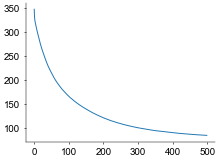

In [113]:
plt.plot(loss_tracker)

In [114]:
model.set_all_params(all_params)  # set new model parameters

In [115]:
model.IF_model.params

{'log_beta': DeviceArray([1.96359624, 1.962971  ], dtype=float64),
 'log_gamma': DeviceArray([0.62920215, 0.63002833], dtype=float64),
 'tau_m': DeviceArray([0.00694127, 0.00688686], dtype=float64),
 'tau_s': DeviceArray([1., 1.], dtype=float64),
 'v_r': DeviceArray([-0.3, -0.3], dtype=float64),
 'v_t': DeviceArray([1., 1.], dtype=float64)}

In [116]:
all_params

{'hyp': {'IF_model': {'log_beta': DeviceArray([1.96359624, 1.962971  ], dtype=float64),
   'log_gamma': DeviceArray([0.62920215, 0.63002833], dtype=float64),
   'tau_m': DeviceArray([0.00694127, 0.00688686], dtype=float64),
   'tau_s': DeviceArray([1., 1.], dtype=float64),
   'v_r': DeviceArray([-0.3, -0.3], dtype=float64),
   'v_t': DeviceArray([1., 1.], dtype=float64)},
  'eps_mapping': {},
  'ic': DeviceArray([[[-1.13357429],
                [-1.18084182]],
  
               [[-1.09797717],
                [-1.38525354]],
  
               [[-1.15651047],
                [-1.29187711]],
  
               [[-1.10172422],
                [-1.3443614 ]],
  
               [[-1.16440337],
                [-1.30868106]]], dtype=float64),
  'lsigma_mapping': {'value': DeviceArray([0.57293694, 0.55069517], dtype=float64)},
  'mu_mapping': {'value': DeviceArray([-0.81691319, -0.81133502], dtype=float64)},
  'state_space': {'kernel': {'lengthscale': DeviceArray([[-1.55567975],
              

<a id='analysis'></a>
## Analysis

In [117]:
spiketrains, q_vh, I, eps_samples = model.sample_posterior_spikes(prng_state, num_samps)

In [118]:
t_eval = np.linspace(-2., 7., 100)  # s
timedata = (model.t, model.dt)

post_mean, post_cov, _ = model.state_space.evaluate_posterior(
    t_eval, timedata, model.state_space.params, model.state_space.var_params, 
    mean_only=False, compute_KL=False, jitter=1e-8)
post_mean = post_mean[..., 0]

evaldata = lib.state_space.get_evaldata(t_eval, timedata)
post_samples, _ = model.state_space.sample_posterior(
    model.state_space.params, model.state_space.var_params, prng_state, 100, 
    timedata, evaldata, jitter=1e-8, compute_KL=False)


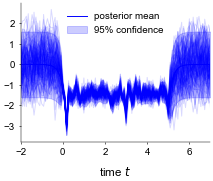

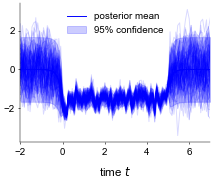

In [119]:
post_var = post_cov[:, np.arange(model.x_dims), np.arange(model.x_dims)]
lb = post_mean - 1.96 * post_var ** 0.5
ub = post_mean + 1.96 * post_var ** 0.5

for plot_out in range(model.f_dims):
    plt.figure()
    plt.plot(t_eval, post_mean[:, plot_out], 'b', label='posterior mean')
    plt.fill_between(t_eval, lb[:, plot_out], ub[:, plot_out], color='b', alpha=0.2, label='95% confidence')
    plt.plot(t_eval, post_samples[..., plot_out, 0], 'b', alpha=0.15)
    plt.xlim([t_eval[0], t_eval[-1]])
    plt.legend()
    plt.xlabel('time $t$')
    plt.show()

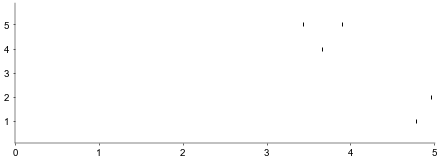

In [120]:
fig = plt.figure(figsize=(6, 2))

widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, 
                         height_ratios=heights, top=1.0, bottom=0.0, left=.0, right=1.0)

ax = fig.add_subplot(spec[0, 0])
    
lib.plots.raster_plot((fig, ax), spiketrains[:, :, 0].T, 
                     time_bins=Tsteps, bin_time=model.dt[1], units=num_samps, colors=None, marker='|', markersize=10)

plt.show()

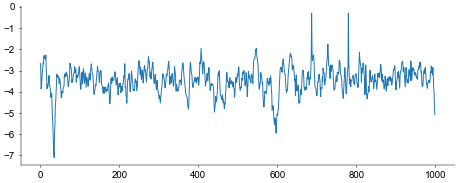

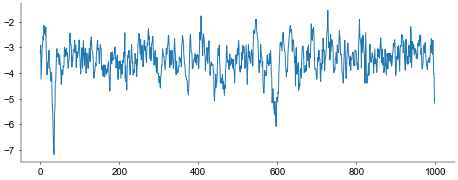

In [121]:
tr, n = 4, 0

fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(q_vh[:, tr, n, 0])
plt.show()


fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(I[:1000, tr, n])
plt.show()

In [129]:
grid = False

if grid: # grid
    n_samp = 10

    xx = np.meshgrid(*[np.linspace(-3, 3, 20) for _ in range(x_dims)])

    xx = np.stack(xx, axis=-1)
    or_shape = xx.shape[:-1]

    xx = xx.reshape(-1, x_dims)
    f_x = obs.sample_prior(n_samp, jax.random.PRNGKey(123), xx) # (samp, f_dim, x_n)
    qf_x = obs.sample_posterior(n_samp, jax.random.PRNGKey(123), xx) # (samp, f_dim, x_n)
    qf_m, qf_c = obs.posterior_predictive(xx)

    f_x = f_x.reshape(n_samp, -1, *or_shape)
    qf_x = f_x.reshape(n_samp, -1, *or_shape)
    qf_m = f_x.reshape(-1, *or_shape)
    qf_c = f_x.reshape(-1, *or_shape)
    
    
else: # line
    n_samp = 10
    x_dim = 0

    xx = np.zeros((100, x_dims))
    xx[:, x_dim] = np.linspace(-3, 3, 100)

    f_x = model.observation.sample_prior(n_samp, jax.random.PRNGKey(123), xx) # (samp, f_dim, x_n)
    qf_x = model.observation.sample_posterior(n_samp, jax.random.PRNGKey(123), xx) # (samp, f_dim, x_n)
    qf_m, qf_c = model.observation.posterior_predictive(xx)
    

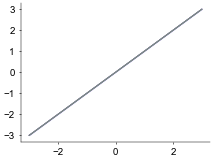

In [130]:
f_dim = 0

n_ps = qf_c.shape[-1]
qf_v = qf_c[:, np.arange(n_ps), np.arange(n_ps)]
lb = qf_m - 1.96 * qf_v ** 0.5
ub = qf_m + 1.96 * qf_v ** 0.5

#Kzz = model.observation.compute_intermediates(None, None)['matrices'][0][f_dim, ...]
#induc_u = Kzz @ lib.utils.inv(svgp_site_params['K_prec_K'][f_dim, ...]) @ svgp_site_params['K_eta_mu'][f_dim, :, 0]


plt.plot(xx[:, x_dim], qf_m[f_dim, :], 'b', label='posterior mean')
plt.fill_between(xx[:, x_dim], lb[f_dim, :], ub[f_dim, :], color='b', alpha=0.05, label='95% confidence')
plt.plot(xx[None, :, x_dim].repeat(n_samp, axis=0).T, qf_x[:, f_dim, :].T, alpha=0.3)
#plt.scatter(induc_locs[:, x_dim], induc_u)
plt.show()

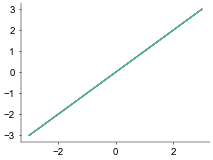

In [131]:
plt.plot(xx[:, x_dim], f_x[:, f_dim, :].T)
plt.show()

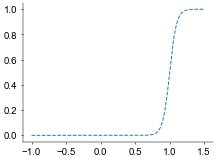

In [64]:
import matplotlib.pyplot as plt
from jax import vmap, grad

t = jnp.linspace(-1., 1.5, 1000)
sg_beta = jnp.exp(3.)
l = sg_beta / jnp.exp(3.)
t_t = 1.
softpl = jax.nn.softplus(-sg_beta*(t-t_t))

pr = np.exp(-softpl / l)


#plt.plot(t, lib.IF_models.heaviside(t, sg_beta))
plt.plot(t, pr, '--')
#plt.plot(t, sg_beta*vmap(grad(heaviside))(sg_beta*t))
#plt.plot(t, sg_beta*vmap(grad(jax.nn.sigmoid))(sg_beta*t), '--')
plt.show()

In [27]:
def make_T(n, a, b, c):
    # Create a psuedo-random tridiagonal Jacobian and store band
    T = jnp.zeros((n, n), dtype=jnp.float32)
    T = T.at[jnp.arange(n-1), jnp.arange(n-1)+1].set(a)
    T = T.at[jnp.arange(n), jnp.arange(n)].set(b)
    T = T.at[jnp.arange(n-1)+1, jnp.arange(n-1)].set(c)
    return T

In [55]:
T = make_T(21, 0.5, 1., 0.5)
eigval, eigvec = jnp.linalg.eig(T)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


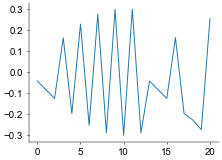

In [57]:
plt.plot(eigvec[0, :])

In [54]:
jnp.real(eigval)

DeviceArray([0.98020405, 0.98081064, 0.9818082 , 0.98317546, 0.9848846 ,
             0.9869025 , 0.98918664, 0.9916916 , 0.99436426, 0.99715406,
             0.99999976, 1.0197967 , 1.0191902 , 1.0181915 , 1.016825  ,
             1.0151157 , 1.0028456 , 1.005635  , 1.0130972 , 1.0083079 ,
             1.010813  ], dtype=float32)

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


import pickle

import sys
sys.path.append("../../neuroppl/")
sys.path.append("..")
sys.path.append("../scripts/")


import neuroppl as nppl
from neuroppl import utils


import matplotlib.pyplot as plt

import os
if not os.path.exists('./saves'):
    os.makedirs('./saves')


import pickle


import lib
import synthetic


gpu_dev = 0
dev = utils.pytorch.get_device(gpu_dev)
plt.style.use(['paper.mplstyle'])

In [17]:
# data
checkpoint_dir = '../scripts/checkpoint/'
datatype = 1

single_spikes = False
bin_size = 500

dataset_tuple = synthetic.get_dataset(datatype)
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, mdl_name = dataset_tuple
#region_edge = metainfo[0]

# model
ll_mode = 'IPPexp'
filt_mode = ''
map_mode = 'svgp32'
x_mode = 'hd-isi1'
z_mode = ''
hist_len = 0
folds = 5
delays = [0]
m = (ll_mode, filt_mode, map_mode, x_mode, z_mode, hist_len, folds, delays)

# load
cv_run = -1
delay = 0
batch_size = 5000

inputs_used = lambda *args: synthetic.inputs_used_(datatype, *args)
enc_used = lambda *args: synthetic.enc_used_(datatype, *args)

modelfit, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, m, dataset_tuple, inputs_used, enc_used, 
    delay, cv_run, batch_size, gpu_dev, tensor_type=torch.float, jitter=1e-5, J=100
)

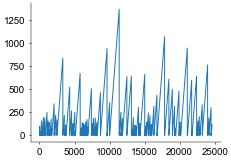

In [19]:
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, mdl_name = dataset_tuple

plt.plot(rcov[1][2, :, 0])

In [78]:
steps = 1000
covariates = [torch.linspace(0, 2*np.pi, steps)*0, torch.linspace(0, 1000.0, steps)]

use_neuron = [0, 1, 2]
trials = 1

cov = modelfit.mapping.to_XZ(covariates, trials)
with torch.no_grad():
    F_mu, F_var = modelfit.mapping.compute_F(cov)


with torch.no_grad():
    modelfit.mapping.jitter = 1e-4
    mc = 10
    eps = torch.randn(mc, 50, 1000, device=modelfit.mapping.dummy.device)
    F = modelfit.mapping.sample_F(cov, eps)

In [79]:
modelfit.mapping.kernel.kern1

DeepKernel(
  (kern): RBF()
  (map): time_transform()
)

In [80]:
x = torch.exp(F)
p = x*torch.exp(-torch.cumsum(x, dim=-1)*0.001)

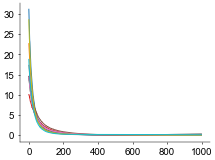

In [90]:
plt.plot(p[:, 26, :].cpu().numpy().T)
plt.show()

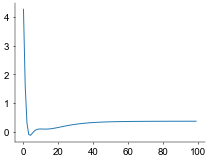

In [28]:
n = 3
fm = F_mu.cpu().numpy()[0, n, :]

plt.plot(fm)

In [32]:
x = np.exp(fm)
p = x*np.exp(-np.cumsum(x, axis=1)*dt) # natural time

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
tau = np.arange(Tl)*dt
tau_0 = 0.001
t = tau_0*(np.exp(tau) - 1)
dtau_dt = 1/(t+tau_0)

In [ ]:
(p*dt).sum(1)

### Neural data

In [ ]:
# Synthetic data
sample_bin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
    syn_t_spike, spike_samples, units, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/synthetic/gauss_pop_cond.p', 'rb'))

max_speed = s_t.max()
wrap_theta_t = tools.WrapPi(theta_t, True)

arena_width = (right_x - left_x)
arena_height = (top_y - bottom_y)
behav_list = [x_t, y_t]

bin_size = 1
T = 50000
tbin, resamples, rc_t, rbehav_t = neural_utils.BinTrain(bin_size, sample_bin, [s[s < T] for s in syn_t_spike], T, 
                                                        tuple(behav_list), average_behav=False)

In [1]:
# Real data

In [ ]:
len(syn_t_spike[0])

### Model comparison

In [28]:
# full GP-GLM
units_ = units#1
l = 1.*np.ones(units_)
v = 1.*np.ones(units_)
kernels_tuples = [('RBF', 'euclid', np.array([l, l]), v)]
prior_tuple = [(None,), (None,)]#[('Normal', 'euclid', 0.0, 1.0, False, False), ('Normal', 'euclid', 0.0, 1.0, False, False)]
#prior_tuple = [('GP', gp_base_1), ('GP', gp_base_2)]
#prior_tuple = [('RW', 'euclid', 0.0, 1.0, True, True), ('RW', 'euclid', 0.0, 1.0, True, True)]
variational_types = [(None,), (None,)]#[('Normal', 'euclid'), ('Normal', 'euclid')]

num_induc = 16
inducing_points = np.array([left_x + arena_width*np.random.rand(num_induc), \
                            bottom_y + arena_height*np.random.rand(num_induc)]).T[None, ...].repeat(units, axis=0)

glm_rate = mdl.nonparametrics.GP_covariates(units, inducing_points, kernels_tuples, 
                                          prior_tuple, variational_types,
                                          shared_kernel_params=False, full_cov_fit=False)
glm_rate.set_params(tbin, jitter=1e-4)

likelihood = mdl.likelihoods.Poisson(units, 'exp')
likelihood.set_params(tbin)


    
# NLL model
gp = False
if gp:
    hist_len = 99 # 100 steps of spiketrain, no instantaneous element
    hist_couple = mdl.filters.GP_filter(units, units, hist_len, tbin, conv_groups=1, tens_type=torch.float)
else:
    w_h = np.zeros((2, 5, 5))
    phi_h = np.ones((2, 5, 5))

    hist_len = 99 # 100 steps of spiketrain, no instantaneous element
    hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len)

glm = mdl.inference.nll_optimized([glm_rate], likelihood, spk_couple=hist_couple)
glm.to(dev)

In [55]:
# preprocessing
ini_X = [rbehav_t[0], rbehav_t[1]]

glm.preprocess(ini_X, resamples, rc_t, batch_size=50000)
glm.to(dev)

sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-2}#, 'lv_std_0': 5*1e-3, 'lv_std_1': 5*1e-3, 'kernel.lengthscale': 5*1e-3}
glm.set_optimizers(opt_tuple, opt_lr_dict)

# fit to population
annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, margin=1e1, premature=100, anneal_func=annealing, 
                 cov_samples=1, ll_samples=10)

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

torch.Size([1, 5, 49901])
torch.Size([1, 5, 49901])
torch.Size([1, 5, 49901])
torch.Size([1, 5, 49901])
torch.Size([1, 5, 49901])


KeyboardInterrupt: 

In [205]:
names = list(glm.named_parameters())
print([n[0] for n in names])
print(glm.rate_model[0].u_scale_tril_unconstrained.shape)
print(glm.spk_couple.GP.u_scale_tril_unconstrained.shape)

['rate_model.0.mean', 'rate_model.0.Xu', 'rate_model.0.u_loc', 'rate_model.0.u_scale_tril', 'rate_model.0.kernel.variance', 'rate_model.0.kernel.lengthscale', 'spk_couple.GP.mean', 'spk_couple.GP.Xu', 'spk_couple.GP.u_loc', 'spk_couple.GP.u_scale_tril', 'spk_couple.GP.kernel.variance', 'spk_couple.GP.kernel.lengthscale']


ModuleAttributeError: 'GP_covariates' object has no attribute 'u_scale_tril_unconstrained'

In [202]:
def get_field(glm_rate, grid_size, grid_shape, neuron):

    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = [x, y]
        return glm_rate.eval_rate(covariates, neuron).reshape(-1, *prevshape)

    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    return field


def compute_rate(glm_rate, neuron):
    grid_size = [50, 40]
    grid_shape = [[left_x, right_x], [bottom_y, top_y]]
    field = get_field(glm_rate, grid_size, grid_shape, neuron)
    return field

def compute_stats(glm_rate, t_spike): # statistics
    bs = 5000
    T = 100000
    N = int(np.ceil(T/bs))
    rate_model= []
    t_spike = t_spike[t_spike < T]

    for n in range(N):
        covariates_ = tuple(b[n*bs:(n+1)*bs] for b in behav_data)
        rate_model += [glm_rate.eval_rate(covariates_, [0])[0]]

    rate_model = np.concatenate(rate_model)

    # Overdispersion count method
    #traj_len = 1000
    #q_cdf_, q_order_, py, T_DS, T_KS, s_DS, s_KS_, p_DS_, p_KS_, traj_lens = \
    #    stats.count_KS_method(sample_bin, t_spike, rate_model, traj_len, min_spikes=10, repeat=1)

    # ISI KS-method
    dist_isi = mdl.point_process.ISI_gamma(np.array([1.0]))
    q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS = \
        stats.ISI_KS_method(dist_isi, sample_bin, t_spike, rate_model)

    return q_cdf, Z_DS, T_KS, s_KS

In [203]:
grid_size = [50, 40]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
field = get_field(glm_rate, grid_size, grid_shape, np.arange(units))

torch.Size([5, 5, 5])
torch.Size([5, 5, 5])


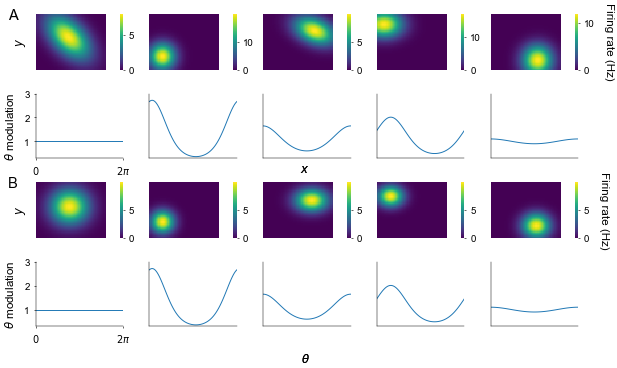

In [39]:
fig = plt.figure(figsize=(10, 6))
fig.text(-0.4, 0.9, 'A', transform=axes[0].transAxes, size=15)
fig.text(-0.4, 0.9, 'B', transform=axes[2*len(unit_used)].transAxes, size=15)


# Gaussian fields IPP ground truth
tmu = np.array([[250., 250.], [100., 100.], [400., 300.], [50., 350.], [360., 70.]])*1e-3
tprec = np.array([[0.0001, 0.0001, 0.00005], [0.0002, 0.0002, 0.0], [0.0001, 0.0002, 0.00005], 
                 [0.0001, 0.0002, 0.0], [0.00015, 0.00015, 0.0]])*1e6
trate_0 = np.array([8.0, 20.0, 10.0, 17.0, 12.0]) # Hz
tt_p = np.array([[0.0, 0.0], [1.0, 0.2], [0.5, 0.0], [0.7, 1.0], [0.1, 0.0]]) # beta, phi_0 for theta modulation

gauss_rate = mdl.parametrics.Gauss_GLM(trate_0.shape[0], 'exp')
gauss_rate.set_params(sample_bin, mdl.parametrics.gaussian_to_w(tmu, tprec, trate_0, tt_p)[:, :6])

grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]


# ground truth
widths = [1, 1]
heights = [1, 1, 1, 1, 1]
nrows = 5
ncols = 2
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0., right=0.2, bottom=0., top=1.)



for neuron in show_neurons:
    
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        theta = (tt_p[neuron, 1]+0.5*np.pi)*np.ones(len(x)) # plot at unit modulation
        covariates = [x, y, theta]
        return gauss_rate.eval_rate(covariates, [neuron])[0].reshape(*prevshape)

    if neuron == 4:
        #cbar= True
        ticktitle='Firing rate (Hz)'
    else:
        #cbar = False
        ticktitle=''
        
    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    _, ax = tools.visualize_field(field, grid_shape, ticktitle=ticktitle, figax=(fig, axes[neuron]))
    if neuron == 0:
        ylabel=r'$y$'
    else:
        ylabel=None
    tools.decorate_ax(ax, ylabel=ylabel, xlim=[left_x, right_x], ylim=[bottom_y, top_y],
                      spines=[False, False, False, False])






plt.savefig('output/cond_pop.svg')
plt.savefig('output/cond_pop.pdf')
plt.show()

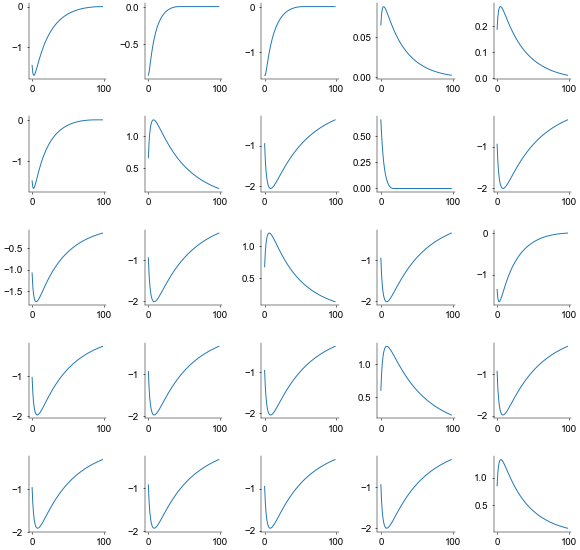

In [53]:
fig = plt.figure(figsize=(10, 10))
nrows = units
ncols = units
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

a = hist_couple().data.cpu().numpy()

for k in range(nrows):
    for l in range(ncols):
        axes[k*ncols + l].plot(a[k, l, ::-1])

fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [54]:
# coupling matrix magnitude
A = a.data.cpu().numpy().mean(-1)

white = '#ffffff'
black = '#000000'
red = '#ff0000'
blue = '#0000ff'
weight_map = tools.make_cmap([blue, white, red], 'weight_map')


fig, ax, im = tools.draw_2d(A, origin='lower', cmap=weight_map, vmin=A.min(), vmax=A.max())
tools.decorate_ax(ax, spines=[False, False, False, False])
tools.add_colorbar(im, fig, ax, cbar_size='5%', ticktitle='coupling strength')

AttributeError: 'memoryview' object has no attribute 'cpu'

In [ ]:
# compute Hessian
glm.preprocess(rbehav_t, rc_t, batch_size=100000)#samples)
H = tools.hessian(glm.nll(0), glm.w_h).data.cpu().numpy()
ss = H.shape[0]*H.shape[1]
H = H.reshape(ss, ss)
w, v = np.linalg.eigh(H)
W.append(w)
V.append(v)

In [9]:
# sample spike raster
T = 5000
trials = 2
ini_train = rc_t[None, :, :glm.h_len-1].repeat(trials, axis=0)
cov = np.array(rbehav_t)[:, :T]
tr = glm.sample(list(cov), ini_train)

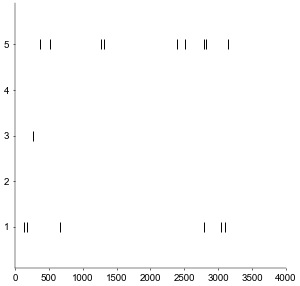

In [10]:
trial = 0
tools.raster_plot((5, 5), tr[trial], 5000, sample_bin*1000, units_used, markersize=100)
plt.show()

In [31]:
# GP fit and compare lengthscales
num_induc = 30
inducing_points = np.array([left_x + arena_width*np.random.rand(num_induc), \
                            bottom_y + arena_height*np.random.rand(num_induc)]).T[None, ...].repeat(units_used, axis=0)

l = np.ones(units_used)
v = np.ones(units_used)


kt = [('RBF', 'euclid', np.array([l, l]), v)]

glm_rate = mdl.nonparametrics.GP_covariates(units_used, inducing_points, kt, ([None],)*2, ([None],)*2, 
                                            inv_link='exp', shared_kernel_params=False, 
                                            jitter=1e-4, mean_ini=np.zeros((1, units_used, 1)))
glm_rate.set_params(sample_bin)

likelihood = mdl.likelihoods.Poisson(units_used, 'exp')
likelihood.set_params(sample_bin)

# NLL model
hist_len = 99 # 100 steps of spiketrain, no instantaneous element
hist_couple = mdl.filters.GP_filter(units_used, units_used, hist_len, sample_bin)

glm = mdl.inference.nll_optimized([glm_rate], likelihood, spk_couple=hist_couple)
glm.preprocess([r for r in rbehav_t[:2]], resamples, rc_t, batch_size=10000)
glm.to(dev)


# fit
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-2}
glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: min(1.0, 0.005*x)
losses = glm.fit(1000, margin=1e0, anneal_func=annealing)

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

RuntimeError: Sizes of tensors must match except in dimension 0. Got 25 and 5 (The offending index is 0)

In [ ]:
# show fits
grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

fig = plt.figure(figsize=(14, 4))
nrows = 2
ncols = 5
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for n in range(units_used):
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        #theta = np.zeros(len(x))
        covariates = np.array([x, y])#, theta)
        return glm_rate.eval_rate(covariates, [n])[0].reshape(*prevshape)

    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    _, ax = tools.visualize_field(field, grid_shape, figax=(fig, axes[n]))

    #l_x = glm_rate.kernel_.lengthscale[0].item()
    #l_y = glm_rate.kernel_.lengthscale[1].item()
    l_x = glm_rate.kernel.lengthscale[n, 0].item()
    l_y = glm_rate.kernel.lengthscale[n, 1].item()
    ax.text(10.0, 10.0, r'$l_{x}=$'+'${:.1f}$ mm'.format(l_x), color='w', fontsize=14)
    ax.text(10.0, 50.0, r'$l_{y}=$'+'${:.1f}$ mm'.format(l_y), color='w', fontsize=14)

fig.subplots_adjust(wspace=0.3)
    
#plt.savefig('output/gp_lengthscales.svg')
#plt.savefig('output/gp_lengthscales.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
nrows = units_used
ncols = units_used
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

a = glm.raised_cosine_bumps(glm.a, glm.c, glm.w_h, glm.phi_h, glm.h_len-1)

for k in range(nrows):
    for l in range(ncols):
        axes[k*ncols + l].plot(a.data[k,l].cpu().numpy()[::-1])

fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

#a = glm.raised_cosine_bumps(glm.a, glm.c, glm.w_u, glm.phi_u, glm.h_len)
#plt.plot(a.data[0,0].cpu().numpy())
#plt.show()

In [ ]:
# coupling matrix magnitude
A = a.data.cpu().numpy().mean(-1)

white = '#ffffff'
black = '#000000'
red = '#ff0000'
blue = '#0000ff'
weight_map = tools.make_cmap([blue, white, red], 'weight_map')


fig, ax, im = tools.draw_2d(A, origin='lower', cmap=weight_map, vmin=A.min(), vmax=A.max())
tools.decorate_ax(ax, spines=[False, False, False, False])
tools.add_colorbar(im, fig, ax, cbar_size='5%', ticktitle='coupling strength')

In [ ]:
# compute Hessian
glm.preprocess(rbehav_t, rc_t, batch_size=100000)#samples)
H = tools.hessian(glm.nll(0), glm.w_h).data.cpu().numpy()
ss = H.shape[0]*H.shape[1]
H = H.reshape(ss, ss)
w, v = np.linalg.eigh(H)
W.append(w)
V.append(v)

In [ ]:
trial = 0
tools.raster_plot((5, 5), tr[trial], 5000, sample_bin*1000, units_used, markersize=100)
plt.show()